# Data Science with Python and Neo4j

## Packages You'll Need

```
pip install py2neo
pip install ipython-cypher
pip install pandas
pip install networkx
pip install python-igraph
```

## Contents

* py2neo
* ipython-cypher
  - pandas
  - NetworkX
* igraph
* graph3d

# py2neo

`py2neo` is one of Neo4j's Python drivers. It offers a fully-featured interface for interacting with your data in Neo4j. Install `py2neo` with `pip install py2neo`.

## Connect

Connect to Neo4j with the `Graph` class.

In [1]:
from py2neo import Graph
from scripts.vis import draw

graph = Graph()

graph.delete_all()

## Nodes

Create nodes with the `Node` class. The first argument is the node's label. The remaining arguments are an arbitrary amount of node properties or key-value pairs.

In [2]:
from py2neo import Node

nicole = Node("Person", name="Nicole", age=24)
drew = Node("Person", name="Drew", age=20)

mtdew = Node("Drink", name="Mountain Dew", calories=9000)
cokezero = Node("Drink", name="Coke Zero", calories=0)

coke = Node("Manufacturer", name="Coca Cola")
pepsi = Node("Manufacturer", name="Pepsi")

graph.create(nicole, drew, mtdew, cokezero, coke, pepsi)

options = {"Person": "name", "Drink": "name", "Manufacturer": "name"}

draw(graph, options)

## Relationships

Create relationships between nodes with the `Relationship` class.

In [3]:
from py2neo import Relationship

graph.create(Relationship(nicole, "LIKES", cokezero))
graph.create(Relationship(nicole, "LIKES", mtdew))
graph.create(Relationship(drew, "LIKES", mtdew))
graph.create(Relationship(coke, "MAKES", cokezero))
graph.create(Relationship(pepsi, "MAKES", mtdew))

draw(graph, options)

## Cypher

Retrieve Cypher query results with `Graph.cypher.execute`.

In [4]:
query = """
MATCH (person:Person)-[:LIKES]->(drink:Drink)
RETURN person.name AS name, drink.name AS drink
"""

data = graph.cypher.execute(query)

data

   | name   | drink       
---+--------+--------------
 1 | Nicole | Mountain Dew
 2 | Nicole | Coke Zero   
 3 | Drew   | Mountain Dew

Rows can be accessed by index.

In [5]:
data[0]

 name   | drink       
--------+--------------
 Nicole | Mountain Dew

Columns can be accessed by key or attribute.

In [6]:
for row in data:
    print "{0} likes to drink {1}.".format(row["name"], row.drink)

Nicole likes to drink Mountain Dew.
Nicole likes to drink Coke Zero.
Drew likes to drink Mountain Dew.


## Parameterized Cypher

Pass parameters to Cypher queries by passing additional key-value arguments to `Graph.cypher.execute.` Parameters in Cypher are named and are wrapped in curly braces.

In [7]:
query = """
MATCH (p:Person)-[:LIKES]->(drink:Drink)
WHERE p.name = {name}
RETURN p.name AS name, AVG(drink.calories) AS avg_calories
"""

data = graph.cypher.execute(query, name="Nicole")

data

   | name   | avg_calories
---+--------+--------------
 1 | Nicole |       4500.0

# ipython-cypher

`ipython-cypher` exposes `%cypher` magic in Jupyter. Install `ipython-cypher` with `pip install ipython-cypher`.

In [8]:
%load_ext cypher

## Cypher

`%cypher` is intended for one-line Cypher queries and `%%cypher` is intended for multi-line Cypher queries. Placing `%%cypher` above a Cypher query will display that query's results.

In [9]:
%%cypher
MATCH (person:Person)-[:LIKES]->(drink:Drink)
RETURN person.name, drink.name, drink.calories

3 rows affected.


person.name,drink.name,drink.calories
Nicole,Mountain Dew,9000
Nicole,Coke Zero,0
Drew,Mountain Dew,9000


## Pandas Data Frames

Cypher query results can be coerced to `pandas` data frames with the `get_dataframe` method. To assign Cypher query results to a variable, you need to use `%cypher` and separate lines with \\. You'll first need to install `pandas` with `pip install pandas`.

In [10]:
results = %cypher MATCH (person)-[:LIKES]->(drink:Drink) \
                  RETURN person.name AS name, drink.name AS drink
    
df = results.get_dataframe()

df

3 rows affected.


,name,drink
0,Drew,Mountain Dew
1,Nicole,Mountain Dew
2,Nicole,Coke Zero


In [11]:
df.index

Int64Index([0, 1, 2], dtype='int64')

In [12]:
df.iloc[[1]]

,name,drink
1,Nicole,Mountain Dew


In [13]:
df["name"]

0      Drew
1    Nicole
2    Nicole
Name: name, dtype: object

# NetworkX Graphs

Cypher query results can be coerced to `NetworkX` MultiDiGraphs, graphs that permit multiple edges between nodes, with the `get_graph` method. You'll first need to install `NetworkX` with `pip install networkx`.

3 rows affected.


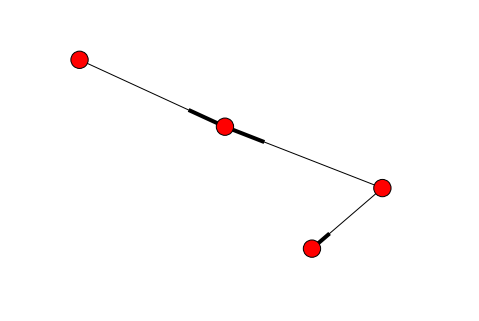

In [14]:
import networkx as nx
%matplotlib inline

results = %cypher MATCH p = (:Person)-[:LIKES]->(:Drink) RETURN p

g = results.get_graph()

nx.draw(g)

In [15]:
g.nodes(data=True)

[(u'1', {u'age': 20, 'labels': [u'Person'], u'name': u'Drew'}),
 (u'0', {u'age': 24, 'labels': [u'Person'], u'name': u'Nicole'}),
 (u'3', {u'calories': 0, 'labels': [u'Drink'], u'name': u'Coke Zero'}),
 (u'2', {u'calories': 9000, 'labels': [u'Drink'], u'name': u'Mountain Dew'})]

In [16]:
nx.degree(g)

{u'0': 2, u'1': 1, u'2': 2, u'3': 1}

# igraph

Cypher query results can be imported into `igraph` with `py2neo`. You'll need to install `igraph` with `pip install python-igraph`. Query results should be returned as edgelists, as `igraph` has a method for building an `igraph` object from a list of tuples representing edges between nodes.

In [17]:
from py2neo import Graph as PGraph
from igraph import Graph as IGraph

neo4j = PGraph()

query = """
MATCH (person:Person)-[:LIKES]->(drink:Drink)
RETURN person.name, drink.name
"""

data = neo4j.cypher.execute(query)
data

   | person.name | drink.name  
---+-------------+--------------
 1 | Nicole      | Mountain Dew
 2 | Nicole      | Coke Zero   
 3 | Drew        | Mountain Dew

In [18]:
ig = IGraph.TupleList(data)

ig

In [19]:
best = ig.vs.select(_degree = ig.maxdegree())["name"]
best

[u'Nicole', u'Mountain Dew']

## graph3d

`graph3d`, originally named `igraph` but which I've renamed to avoid conflicts with the other `igraph`, will plot tuple lists as 3D graphs.

In [20]:
import graph3d

graph3d.draw([(1, 2), (2, 3), (3, 4), (4, 1), (4, 5), (5, 2)])

We can visualize our Neo4j data by pulling out an edgelist with a Cypher query.

In [21]:
from py2neo import Graph

graph = Graph()

data = graph.cypher.execute("MATCH (n)-->(m) RETURN ID(n), ID(m)")
data = [tuple(x) for x in data]

graph3d.draw(data)